In [1]:
%matplotlib inline
import numpy as np
import os
import gyroradius
from my_tools import get_next_name
import matplotlib.pyplot as plt
import re
import ROOT
from collections import defaultdict

Welcome to JupyROOT 6.20/02


In [3]:
os.getcwd()

'/home/tsrunchev/CLionProjects/antimatter_detector/python'

In [5]:
loadpath = f'../python_data/temp/'

In [6]:
# pattern = 'rejOut_(\d*)_nonSmearedr_01\.csv' # These are all named wrongly because I'm an idiot

In [7]:
files = [i for i in os.listdir(loadpath)]# if re.match(pattern,i)]

In [8]:
# files

### A single data file contains data from protons launched at the detector at a random small angle (small enough to pass through both ends) at a single momentum. Each simulation data point (there's ~10 per file) has been smeared 1000 times and put into the file (with some outliers removed). All 1000 points have the same transverse momentum, hence why I use it as a key to make the collection I then fit.

In [21]:
a = np.array([1,2,3,4,5,6,7,8,9,10])
np.percentile(a,70)

7.3

In [23]:
nbins = 250
sigmas = []
mus = []
chi2 = []
momenta = []
ndofs = []
spacing = []
f = ROOT.TFile(get_next_name(os.path.join(loadpath,'cmosSpacingGausHists.root')), 'CREATE')
# Take all files, each has two columns:
#   transverse momentum, reconstructed radius
for thisfile in files:
    cmos_spacing = float(thisfile.split('_')[1][:-2])
    data = np.loadtxt(f'{loadpath}{thisfile}')
    d = defaultdict(list)
    # Construct dictionary with the key being the transverse momentum
    for key, val,_ in data:
        d[key].append(val)
    for key in d.keys():
        dist_radii = np.array(d[key])
        dist_radii = dist_radii[dist_radii<np.percentile(dist_radii,95)]
        # Create and fill histogram
        h = ROOT.TH1D(f'HistTransverseMomentum_{key:.2f}MeV_{cmos_spacing:.0f}',\
                      'Distribution of smeared reconstructed gyration radius'\
                      f' with partial gaussian fit, transverse momentum {key:.2f}'\
                      f',CMOS spacing {cmos_spacing:.0f} mm;Reconstructed radius [mm];;;',\
                      nbins,dist_radii.min(),dist_radii.max())
        h.Sumw2()
        h.FillN(dist_radii.shape[0],dist_radii, np.ones_like(dist_radii))
        
        # Simple rudimentary fwhm estimator
        fwhmbin1 = h.FindFirstBinAbove(h.GetMaximum()/2)
        fwhmbin2 = h.FindLastBinAbove(h.GetMaximum()/2)
        
        g1 = ROOT.TF1('g1','gaus',h.GetBinLowEdge(fwhmbin1),h.GetBinLowEdge(fwhmbin2+1))
        fitresult = h.Fit('g1','SR')
    
        spacing.append(cmos_spacing)
        mus.append(g1.GetParameter(1))
        sigmas.append(g1.GetParameter(2))
        chi2.append(fitresult.Chi2())
        ndofs.append(fitresult.Ndf())
        momenta.append(key)
#         h.Write()
        fitresult.Write(f'{key:.2f}MeV_fit')
        f.Write()
f.Close()

sigmas = np.array(sigmas)
mus = np.array(mus)
chi2 = np.array(chi2)
momenta = np.array(momenta)
ndofs = np.array(ndofs)
fitresults = np.stack((spacing,momenta,mus,sigmas,chi2,ndofs),axis=1)
np.savetxt(get_next_name(os.path.join(loadpath,'gaus_fit.csv')),fitresults,header='spacing trans_mom mu sigma chi2 ndof')

 FCN=21.2006 FROM MIGRAD    STATUS=CONVERGED     305 CALLS         306 TOTAL
                     EDM=1.45136e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.93295e+01   6.11198e+01   5.60068e-03  -4.18358e-04
   2  Mean        -1.43987e+02   7.06187e+02   3.30605e-02  -6.08405e-05
   3  Sigma        2.73693e+02   2.23279e+02   3.56564e-04  -4.84417e-03
 FCN=16.7796 FROM MIGRAD    STATUS=CONVERGED     111 CALLS         112 TOTAL
                     EDM=2.36744e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.97673e+01   2.83161e+00   4.03246e-03  -7.57740e-07
   2  Mean         4.81694e+01   4.82976e+00   6.35413e-03   6.19683e-06
   3  Sigma        3.23283e+01   

Warning in <Fit>: Abnormal termination of minimization.
Warning in <Fit>: Abnormal termination of minimization.
Warning in <Fit>: Abnormal termination of minimization.
Warning in <Fit>: Abnormal termination of minimization.
Warning in <Fit>: Abnormal termination of minimization.


<IPython.core.display.Javascript object>


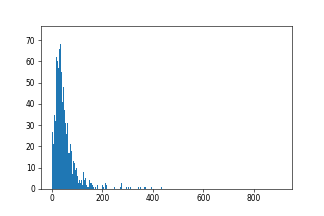

In [27]:
fig,ax = plt.subplots()
hist = ax.hist(sigmas,bins=500)

<IPython.core.display.Javascript object>


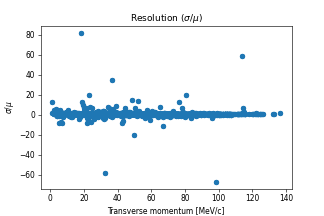

In [28]:
fig,ax = plt.subplots()
ax.plot(momenta,np.array(sigmas)/np.array(mus),'o')

<IPython.core.display.Javascript object>


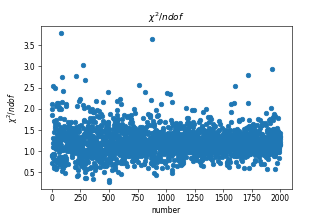

Text(0.5, 0, 'number')

In [41]:
fig,ax = plt.subplots()
ax.plot(chi2/ndofs,'o')
ax.set_title("$\chi^2/ndof$")
ax.set_ylabel("$\chi^2/ndof$")
ax.set_xlabel("number")

In [30]:
(ndofs==0).sum()

0

<IPython.core.display.Javascript object>


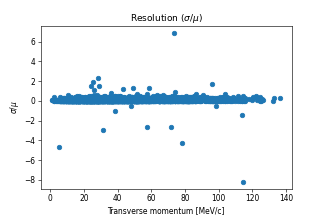

Text(0, 0.5, '$\\sigma/\\mu$')

In [39]:
fig,ax = plt.subplots()
rej_chi2 = (chi2/ndofs) < 10
ax.scatter(momenta[rej_chi2],sigmas[rej_chi2]/mus[rej_chi2])
ax.set_title("Resolution ($\sigma/\mu$)")
ax.set_xlabel('Transverse momentum [MeV/c]')
ax.set_ylabel('$\sigma/\mu$')

In [32]:
%matplotlib notebook
data = np.loadtxt(os.path.join(loadpath,'gaus_fit_01.csv'))
spacing = data[:,0]
sigmas = data[:,3]
mus = data[:,2]

<IPython.core.display.Javascript object>


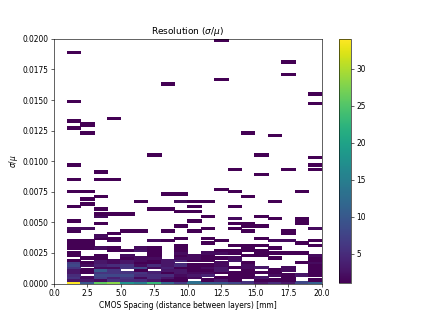

In [43]:
fig,ax = plt.subplots(figsize=(8,6))
# rej_chi2 = (chi2/ndofs) < 1.3
_,_,_,h2d = ax.hist2d(spacing,sigmas/mus,bins=(20,100),cmin=1,range=[[0,20],[0,0.02]])
ax.set_title("Resolution ($\sigma/\mu$)")
ax.set_xlabel('CMOS Spacing (distance between layers) [mm]')
ax.set_ylabel('$\sigma/\mu$')
fig.colorbar(h2d)

In [36]:
sample = data[data[:,0]==5]
s_spacing = sample[:,0]
s_mom = sample[:,1]
s_mus = sample[:,2]
s_sigmas = sample[:,3]
s_chi2 = sample[:,4]
s_ndof = sample[:5]

<IPython.core.display.Javascript object>


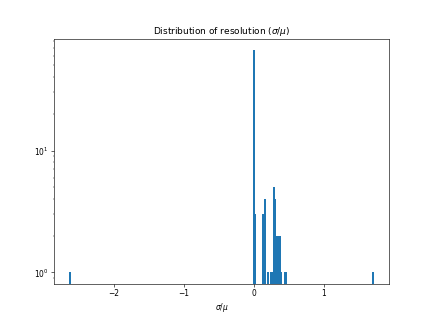

Text(0, 0.5, '')

In [49]:
fig,ax = plt.subplots(figsize=(8,6))
# rej_chi2 = (chi2/ndofs) < 1.3
ax.hist(s_sigmas/s_mus, bins=200, log=True)
ax.set_title("Distribution of resolution ($\sigma/\mu$)")
ax.set_xlabel('$\sigma/\mu$')
ax.set_ylabel('')

In [38]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(s_chi2/s_ndof,'o')
ax.set_title('$\chi^2/ndof$')

<IPython.core.display.Javascript object>

ValueError: operands could not be broadcast together with shapes (100,) (5,6) 